In [1]:
import sys
import os

cwd = os.getcwd()
h, _ = os.path.split(cwd)

sys.path.append(h)

from scripts import viz, metrics

In [2]:
import numpy as np
import pandas as pd

In [3]:
# const
n_runs = 3
n_epochs = 100
batch_size = 128

In [4]:
folders = [
    "ddpm\\23.05_03.40",
    "maf\\31.05_22.11",
    "cvae\\06.06_14.36",
    "supervised\\28.05_19.05",
    "idealized\\09.06_20.16",
]

# Test Data

Load test data for all methods

In [5]:
SR_test = pd.read_csv("../data/evaluation/SR_test.csv")
extrabg_SR_test = pd.read_csv("../data/evaluation/extrabg_SR_test.csv")

SR_test.shape, extrabg_SR_test.shape

((60000, 6), (300000, 6))

In [6]:
test_data = pd.concat([SR_test, extrabg_SR_test]).to_numpy()
test_target = test_data[:, -1]

test_data = test_data
test_data.shape

(360000, 6)

In [7]:
test_target.mean()

0.05555555555555555

In [8]:
import os
from sklearn.metrics import auc
from scripts.metrics import tprs_fprs_sics
from scripts.evaluation_utils import compare_on_various_runs

preds_dict = {}
for fld in folders:
    preds_path = os.path.join(fld, "classifiers", "preds_matrix.npy")
    preds_matrix = np.load(preds_path)
    tprs, fprs, sics = tprs_fprs_sics(preds_matrix, test_target)

    # chose with best auc_sic
    auc_sic = []
    for run_id in range(n_runs):
        auc_sic.append( auc(tprs[(run_id, 0)], sics[(run_id, 0)]) )
    median_run_id = np.argsort(auc_sic).flatten()[n_runs // 2]
    preds_dict[fld] = {
        "tpr": tprs[(median_run_id, 0)],
        "fpr": fprs[(median_run_id, 0)], 
        "sic": sics[(median_run_id, 0)],
    }

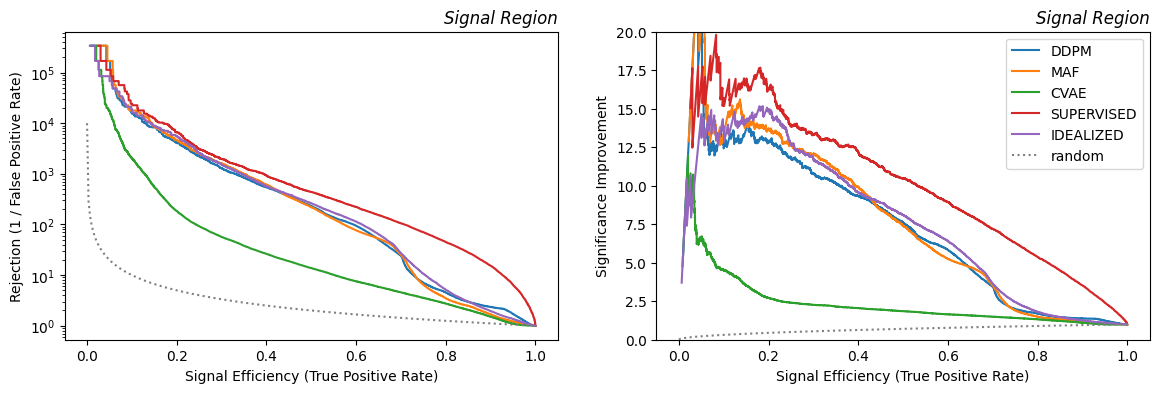

In [9]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(ncols=2, figsize=(14, 4))

for fld, metrics in preds_dict.items():
    model_name = os.path.split(fld)[0].upper()
    fprs, tprs, sics = metrics["fpr"], metrics["tpr"], metrics["sic"]

    axis[0].plot(tprs, 1 / fprs, label=model_name)
    axis[0].set_ylabel('Rejection (1 / False Positive Rate)')
    axis[0].set_xlabel('Signal Efficiency (True Positive Rate)')
    axis[0].set_title(f"Signal Region", loc="right", style='italic')
    axis[0].set_yscale('log')
    
    axis[1].plot(tprs, sics, label=model_name)
    axis[1].set_ylabel('Significance Improvement')
    axis[1].set_xlabel('Signal Efficiency (True Positive Rate)')
    axis[1].set_title(f"Signal Region", loc="right", style='italic')
    axis[1].set_ylim([0, 20])

axis[0].plot(np.linspace(0.0001, 1, 300), 1 / np.linspace(0.0001, 1, 300),
         color="gray", linestyle=":", label="random")
axis[1].plot(np.linspace(0.0001, 1, 300),
             np.linspace(0.0001, 1, 300) / np.linspace(0.0001, 1, 300)**(0.5), color="gray",
             linestyle=":", label="random")
plt.legend()
plt.show()